In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context='notebook', style='white', font_scale=1.6, color_codes=True)
plt.style.use('dark_background')


# Sparse Regression

Here we compare models of fully Bayesian sparse linear regression with pairwais interaction terms. We start by introducing hierarchical shrinkage priors in the form of regularised horseshoe distribution [1], next we introduce QR decomposition and illustrate its utility in the presence of highly corelated predictors (elements of the design matrix) [2], and finally introduce the sparse kernel interaction model (SKIM) proposed in [3]. SKIM is particularly suitable for situations with many feature dimensions (large D) but not too many datapoints (small N).

We will consider a quadratic regressor of the form:

\begin{equation}
    \begin{split}
        f\left( X, \pmb{\beta} \right) &= \alpha + \sum_i \beta_i X_i + \sum_{i<j} \beta_{ij} X_i X_j \\
        y &\sim p \left(y | f\left( X, \pmb{\beta} \right), \theta  \right)
    \end{split}
\end{equation}

In the case of normal likelihood, that is:

$$ p \left(y | f\left( X, \pmb{\beta} \right), \theta  \right) = \mathcal{N} \left(y; f(X, \pmb{\beta}), \sigma^2 \right) $$

we are dealing with a linear regression problem. In the case of Bernoulli likelihood, that is:

$$ p \left(y | f\left( X, \pmb{\beta} \right), \theta  \right) = s \left( f(X, \pmb{\beta}) \right)^y \left(1 - s \left( f(X, \pmb{\beta}) \right) \right)^{1-y}; \:\: \text{for } y \in \{ 0, 1 \} $$

we are dealing with a logistic regression problem.

**References:**

    1. Piironen, Juho, and Aki Vehtari (2017),  
        "Sparsity information and regularization in the horseshoe and other shrinkage priors." 
        Electronic Journal of Statistics 11.2 : 5018-5051.
        
    2. https://mc-stan.org/users/documentation/case-studies/qr_regression.html

    3. Raj Agrawal, Jonathan H. Huggins, Brian Trippe, Tamara Broderick (2019), 
       "The kernel interaction trick: Fast bayesian discovery of pairwise interactions in high dimensions." 
       International Conference on Machine Learning. PMLR.

In [2]:
import itertools
import numpyro
numpyro.set_platform("cpu")
num_chains=1
numpyro.set_host_device_count(num_chains)
numpyro.enable_validation(True)

import numpy as np

import jax
from jax import vmap, nn
import jax.numpy as jnp
import jax.random as random
# from jax.scipy.linalg import cho_factor, cho_solve, solve_triangular
# from scipy.cluster.vq import kmeans2

import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, init_to_feasible
from numpyro.infer.reparam import TransformReparam
from numpyro.distributions.transforms import Transform, AffineTransform, ComposeTransform

In [3]:
# Create artificial regression dataset where only S out of P feature
# dimensions contain signal. If pairwise=True then there is a single 
# pairwise interaction between the first and second dimensions.
def get_data(X, S=2, sigma=1., pairwise=False, logistic=False):
    N, D = X.shape
    assert S < D and D > 1 and S > 0

    np.random.seed(101)

    # generate S coefficients with non-negligible magnitude
    W = 0.15 + 0.85 * np.random.rand(S)
    if pairwise:
        # generate data using the S coefficients and a single pairwise interaction
        f = np.sum(X[:, 0:S] * W, axis=-1) + X[:, 0] * X[:, 1]
    else:
        f = np.sum(X[:, 0:S] * W, axis=-1)
        
    if logistic:
        Y = random.bernoulli(random.PRNGKey(0), p=nn.sigmoid(f))
        return X, Y, W, 1.0
    else:
        Y = f + sigma * np.random.randn(N)
        Y -= jnp.mean(Y)
        Y_std = jnp.std(Y)       
        return X, Y/Y_std, W / Y_std, 1.0 / Y_std

In [4]:
import numpyro.distributions as dist

S = 5
D = 50
N = 200

X = np.random.randn(N, D)
X, Y1, expected_thetas1, expected_pairwise = get_data(X, S=S, pairwise=False, logistic=False)

print(expected_thetas1)

[0.39155012 0.4222183  0.1158172  0.1966553  0.48698562]


# Bayesian linear regression

Given a normal likelihood 
$$ p \left(y | f\left( X, \pmb{\beta} \right), \theta  \right) = \mathcal{N} \left(y; f(X, \pmb{\beta}), \sigma^2 \right) $$

and the following prior over regression coefficients
$$ p(\pmb{\beta}) = \mathcal{N}_D\left(\pmb{\beta}; 0, \tau^2 \pmb{\Lambda} \right); \:\: \text{for } \pmb{\Lambda} = diag(\lambda_1^2, \ldots, \lambda_D^2)$$

The posterior for the coefficients $\pmb{\beta}$ given the (hyper)paramters and data $\mathcal{D} = \left( \pmb{X}, \pmb{y} \right)$ is
\begin{equation}
    \begin{split}
        p\left(\pmb{\beta}|\pmb{\Lambda}, \tau, \sigma, \mathcal{D} \right) &= \mathcal{N}\left(\pmb{\beta}; \bar{\pmb{\beta}}, \pmb{\Sigma} \right) \\
        \hat{\pmb{\beta}} &= \left( \pmb{X}^T \pmb{X} \right)^{-1} \pmb{X}^T \pmb{y} \\
        \bar{\pmb{\beta}} &= \tau^2 \pmb{\Lambda} \left( \tau^2 \pmb{\Lambda} + \sigma^2 \left(\pmb{X}^T \pmb{X} \right)^{-1} \right)^{-1} \hat{\pmb{\beta}}\\
        \pmb{\Sigma} &= \left( \frac{1}{\tau^2} \pmb{\Lambda}^{-1} + \frac{1}{\sigma^2} \pmb{X}^T \pmb{X} \right)^{-1} 
    \end{split}
\end{equation}

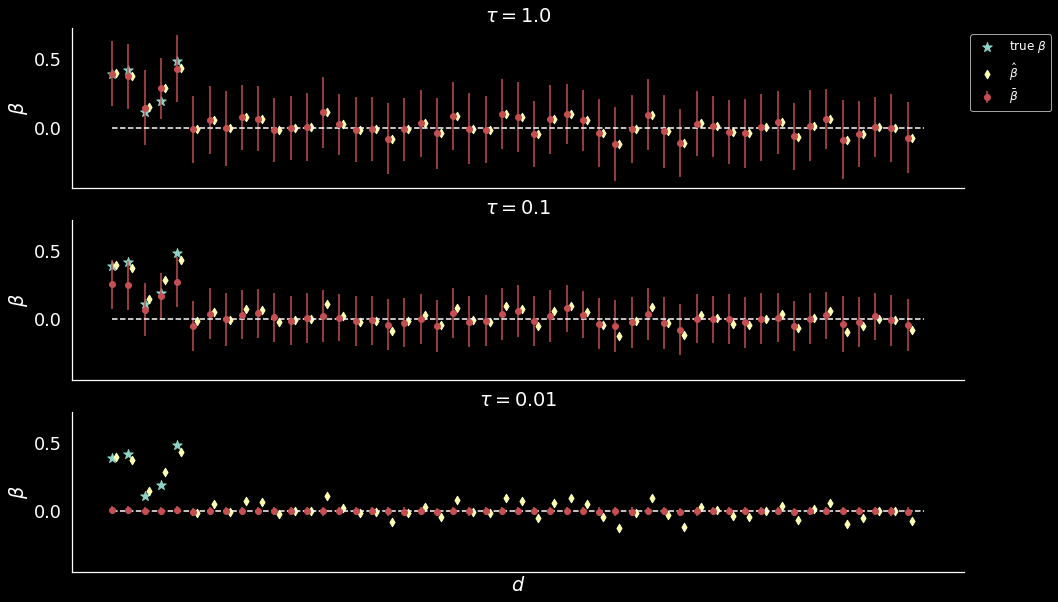

In [6]:
def blr(X, y, tau=1, sigma=1):
    # bayesian linear regression
    N, D = X.shape
    Lambda = np.eye(D)
    S = X.T @ X
    hat_beta = np.linalg.inv(S) @ X.T @ y
    bar_beta = tau**2 * Lambda @ np.linalg.inv(tau**2*Lambda + sigma**2 * np.linalg.inv(S)) @ hat_beta 
    Sigma = np.linalg.inv( np.linalg.inv(Lambda)/tau**2 + S/sigma**2)
    return bar_beta, hat_beta, Sigma

fig, axes = plt.subplots(3, 1, figsize=(16, 10), sharex=True, sharey=True)
tau = [1., .1, .01]
for i in range(3):
    bar_beta, hat_beta, Sigma = blr(X, Y1, tau=tau[i])
    axes[i].errorbar(np.arange(1, D + 1), bar_beta, yerr=3*np.sqrt(np.diag(Sigma)), color='r', marker='o', ls='', label=r'$\bar{\beta}$')
    axes[i].scatter(np.arange(1, S+1), expected_thetas1, marker='*', s=100, label=r'true $\beta$')
    axes[i].scatter(np.arange(1, D + 1) + .25, hat_beta, marker='d', label=r'$\hat{\beta}$')
    axes[i].hlines(0, 1, D + 1, 'w', ls='--')
    axes[i].set_ylabel(r'$\beta$')
    axes[i].set_title(r'$\tau={}$'.format(tau[i]))

axes[-1].set_xticks([])
axes[-1].set_xlabel(r'$d$')
axes[0].legend(bbox_to_anchor=(1,1), loc="upper left", fontsize=12)
sns.despine()

fig.savefig('blr_example.png', transparent=True, bbox_inches='tight', dpi=300)

In [7]:
from jax import nn, lax
from numpyro.distributions import constraints

class QRTransform(Transform):
    domain = constraints.real_vector
    codomain = constraints.real_vector

    def __init__(self, R, R_inv):
        if jnp.ndim(R) != 2:
            raise ValueError(
                "Only support 2-dimensional R matrix. "
            )
        self.R = R
        self.R_inv = R_inv

    def __call__(self, x):
        return jnp.squeeze(
            jnp.matmul(self.R, x[..., jnp.newaxis]), axis=-1
        )

    def _inverse(self, y):
        return jnp.squeeze(
            jnp.matmul(self.R_inv, y[..., jnp.newaxis]), axis=-1
        )

    def log_abs_det_jacobian(self, x, y, intermediates=None):
        return jnp.broadcast_to(
            jnp.log(jnp.diagonal(self.R, axis1=-2, axis2=-1)).sum(-1),
            jnp.shape(x)[:-1],
        )

    def forward_shape(self, shape):
        if len(shape) < 1:
            raise ValueError("Too few dimensions on input")
        return lax.broadcast_shapes(shape, self.R.shape[:-1])

    def inverse_shape(self, shape):
        if len(shape) < 1:
            raise ValueError("Too few dimensions on input")
        return lax.broadcast_shapes(shape, self.R.shape[:-1])

class BayesLinRegress(object):
    def __init__(self, rng_key, X, tau=1., p0=None, fixed_lam=True, with_qr=False):
        self.N, self.D = X.shape
        self.X = X
        self.rng_key = rng_key
        self.tau = tau
        self.fixed_lam = fixed_lam
        self.with_qr = with_qr
        self.p0 = p0
        
        if self.with_qr:
            self.Q, self.R = jnp.linalg.qr(X)
            self.R_inv = jnp.linalg.inv(self.R)
        
    def model(self, obs=None):
        sigma_sqr = numpyro.sample('sigma^2', dist.InverseGamma(2., 2.))
        sigma = numpyro.deterministic('sigma', jnp.sqrt(sigma_sqr))
        
        if self.p0 is None:
            tau = self.tau * sigma
        else:
            tau0 = self.p0 * sigma / ((self.D - self.p0) * jnp.sqrt(self.N))
            tau = numpyro.sample('tau', dist.HalfCauchy(tau0))
            
        if self.fixed_lam:
            lam = numpyro.deterministic('lam', jnp.ones(self.D))
        else:
            lam = numpyro.sample('lam', dist.HalfCauchy(1.).expand([self.D]).to_event(1))
            
        if self.with_qr:
            rt = QRTransform(self.R, self.R_inv)
            aff = AffineTransform(0., tau * lam)
            ct = ComposeTransform([aff, rt])
            with handlers.reparam(config={"theta": TransformReparam()}):
                theta = numpyro.sample(
                    'theta', 
                    dist.TransformedDistribution(dist.Normal(0., 1.).expand([D]).to_event(1), ct)
                )

            numpyro.deterministic('beta', rt.inv(theta))
            tmp = self.Q.dot(theta)

        else:
            aff = AffineTransform(0., tau * lam)
            with handlers.reparam(config={"beta": TransformReparam()}):
                beta = numpyro.sample(
                    'beta', 
                    dist.TransformedDistribution(dist.Normal(0., 1.).expand([self.D]).to_event(1), aff)
                )
            tmp = self.X.dot(beta)

        alpha = numpyro.sample('alpha', dist.Normal(0., 10.))
        mu = numpyro.deterministic('mu', alpha + tmp)
        
        with numpyro.plate('data', self.N):
            numpyro.sample('obs', dist.Normal(mu, sigma), obs=obs)
    
    def fit(self, data, num_samples=1000, warmup_steps=1000, num_chains=1, summary=True, progress_bar=True):
        self.rng_key, _rng_key = random.split(self.rng_key)

        nuts_kernel = NUTS(self.model, init_strategy=init_to_feasible)
        mcmc = MCMC(nuts_kernel, 
                    num_warmup=warmup_steps, 
                    num_samples=num_samples, 
                    num_chains=num_chains,
                    chain_method='vectorized',
                    progress_bar=progress_bar)
        mcmc.run(_rng_key, obs=data)

        if summary:
            mcmc.print_summary()

        samples = mcmc.get_samples(group_by_chain=False)
        self.mcmc = mcmc
        self.samples = samples

        return samples

sample: 100%|█| 2000/2000 [00:02<00:00, 669.75it/s, 7 steps of size 4.07e-01. ac
sample: 100%|█| 2000/2000 [00:02<00:00, 675.48it/s, 7 steps of size 4.39e-01. ac
sample: 100%|█| 2000/2000 [00:02<00:00, 691.39it/s, 7 steps of size 4.79e-01. ac


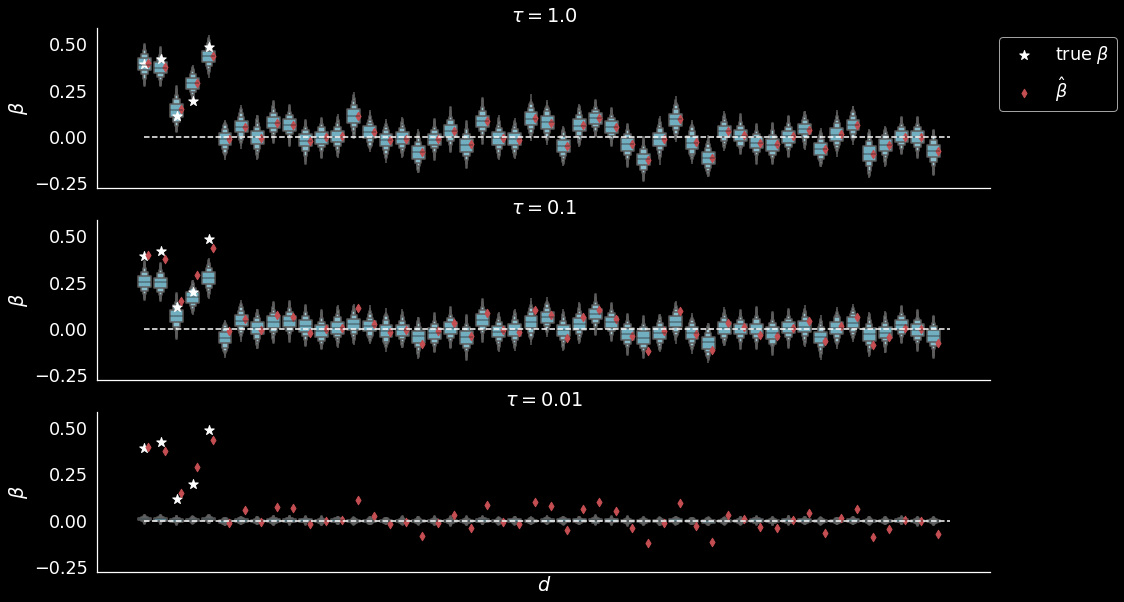

In [8]:
rng_key = random.PRNGKey(101)
fig, axes = plt.subplots(3, 1, figsize=(16, 10), sharex=True, sharey=True)
tau = [1., .1, .01]
for i in range(3):
    rng_key, _rng_key = random.split(rng_key)
    BLR = BayesLinRegress(rng_key, jnp.array(X), tau=tau[i], fixed_lam=True)
    samples = BLR.fit(jnp.array(Y1), summary=False, num_chains=num_chains)
    
    sns.boxenplot(data=np.array(samples['beta']), color='c', ax=axes[i], showfliers=False)
    axes[i].scatter(np.arange(S), expected_thetas1, color='w', marker='*', s=100, label=r'true $\beta$')
    axes[i].scatter(np.arange(D) + .25, hat_beta, color='r', marker='d', label=r'$\hat{\beta}$')
    axes[i].hlines(0, 0, D, 'w', ls='--')
    axes[i].set_ylabel(r'$\beta$')
    axes[i].set_title(r'$\tau={}$'.format(tau[i]))

axes[-1].set_xticks([])
axes[-1].set_xlabel(r'$d$')
axes[0].legend(bbox_to_anchor=(1,1), loc="upper left")
sns.despine()

fig.savefig('example_sampling.png', transparent=True, bbox_inches='tight', dpi=300)

# Horseshoe prior

$$ \lambda_d \sim C^+(0, 1) = \begin{cases} \frac{2}{\pi} \frac{1}{1 + \lambda_d^2}, &\text{for } \lambda_d \geq 0 \\ 0 & \text{otherwise}\end{cases}$$

$$ \bar{\beta}_d = (1 - \kappa_d) \hat{\beta}_d$$
$$ \kappa_d = \frac{1}{1 + N \tau^2 \lambda_d^2 s_d^2}$$
$$ Var(\pmb{x}_d) = s_d^2$$

$$ p(\kappa_d) = \frac{1}{\pi} \frac{a_d}{(a_d^2-1)\kappa_d + 1} \frac{1}{\sqrt{\kappa_d}\sqrt{1 - \kappa_d}}$$
$$ a_d = N \sigma^{-1} \tau s_d$$
when $a_d=1$ we have a prior over $\kappa_d$ in the shape of a horseshoe. 

/tmp/ipykernel_37515/4175475974.py:2: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(kappa, 1/(np.sqrt(kappa)*np.sqrt(1 - kappa)))


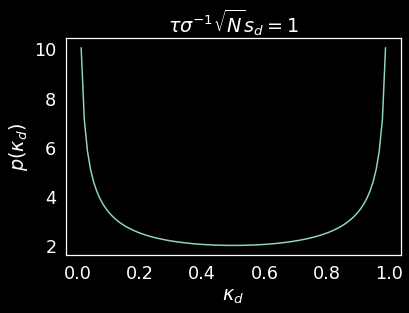

In [16]:
kappa = np.arange(0, 1, 0.01)
plt.plot(kappa, 1/(np.sqrt(kappa)*np.sqrt(1 - kappa)))
plt.ylabel(r'$p(\kappa_d)$');
plt.xlabel(r'$\kappa_d$');
plt.title(r'$\tau \sigma^{-1} \sqrt{N} s_d = 1$');
plt.savefig('horseshoe.png', transparent=True, bbox_inches='tight', dpi=300)

sample: 100%|█| 2000/2000 [00:04<00:00, 437.18it/s, 127 steps of size 2.55e-02. 
sample: 100%|█| 2000/2000 [00:04<00:00, 493.47it/s, 63 steps of size 5.81e-02. a
sample: 100%|█| 2000/2000 [00:03<00:00, 518.41it/s, 63 steps of size 7.49e-02. a


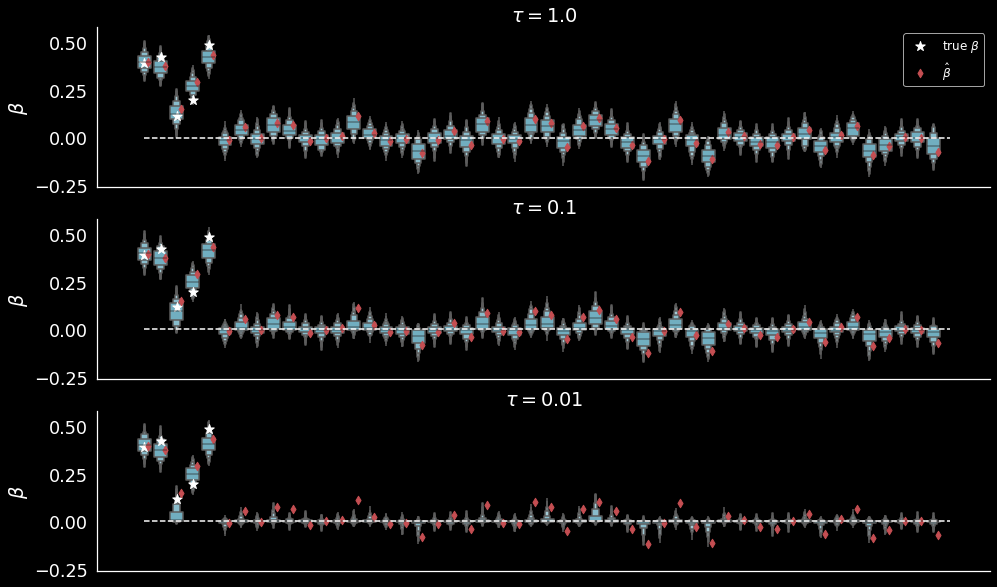

In [18]:
rng_key = random.PRNGKey(101)
fig, axes = plt.subplots(3, 1, figsize=(16, 10), sharex=True, sharey=True)
tau = [1., .1, .01]
for i in range(3):
    rng_key, _rng_key = random.split(rng_key)
    BLR = BayesLinRegress(rng_key, jnp.array(X), tau=tau[i], fixed_lam=False)
    samples = BLR.fit(jnp.array(Y1), summary=False, num_chains=num_chains)
    
    sns.boxenplot(data=np.array(samples['beta']), color='c', ax=axes[i], showfliers=False)
    axes[i].scatter(np.arange(S), expected_thetas1, color='w', marker='*', s=100, label=r'true $\beta$')
    axes[i].scatter(np.arange(D) + .25, hat_beta, color='r', marker='d', label=r'$\hat{\beta}$')
    axes[i].hlines(0, 0, D, 'w', ls='--')
    axes[i].set_ylabel(r'$\beta$')
    axes[i].set_title(r'$\tau={}$'.format(tau[i]))

axes[-1].set_xticks([])
axes[0].legend(loc="upper right", fontsize=12)
sns.despine()
fig.savefig('example_sampling2.png', transparent=True, bbox_inches='tight', dpi=300)

sample: 100%|█| 2000/2000 [00:04<00:00, 447.51it/s, 127 steps of size 5.68e-02. 


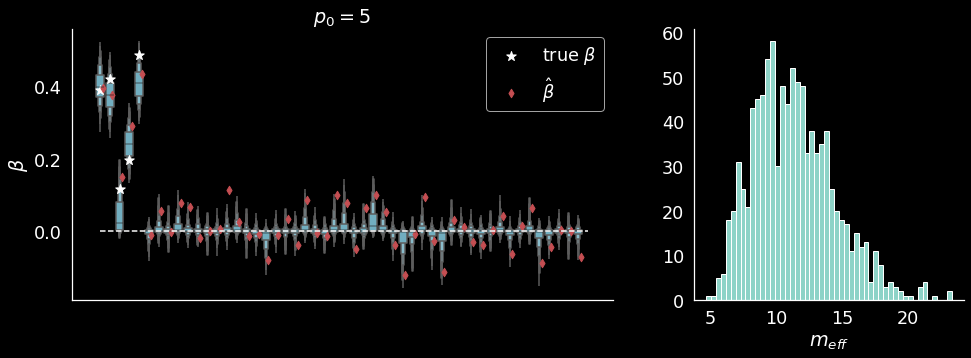

In [21]:
def m_eff(D, N, p0, s_sqr, sigma, tau, lam):
    kappa = 1/(1 + N * jnp.expand_dims(tau, -1)**2 * lam**2 * s_sqr / jnp.expand_dims(sigma, -1) ** 2)
    return jnp.sum( 1 - kappa, -1)

rng_key = random.PRNGKey(101)
fig, axes = plt.subplots(1, 2, figsize=(16, 5), gridspec_kw={'width_ratios': [2, 1], 'wspace': 0.2})
p0 = 5
rng_key, _rng_key = random.split(rng_key)
BLR = BayesLinRegress(rng_key, jnp.array(X), fixed_lam=False, p0=p0)
samples = BLR.fit(jnp.array(Y1), summary=False, num_chains=num_chains)

sns.boxenplot(data=np.array(samples['beta']), color='c', ax=axes[0], showfliers=False)
axes[0].scatter(np.arange(S), expected_thetas1, color='w', marker='*', s=100, label=r'true $\beta$')
axes[0].scatter(np.arange(D) + .25, hat_beta, color='r', marker='d', label=r'$\hat{\beta}$')

axes[0].hlines(0, 0, D, 'w', ls='--')
axes[0].set_ylabel(r'$\beta$')
axes[0].set_title(r'$p_0={}$'.format(p0))
axes[0].set_xticks([])
axes[0].legend(loc="upper right")

m_e = m_eff(D, N, p0, np.var(X, 0, ddof=1), samples['sigma'], samples['tau'], samples['lam'])
axes[1].hist(np.array(m_e), bins=50)
axes[1].set_xlabel(r'$m_{eff}$')

sns.despine()
fig.savefig('full_model.png', transparent=True, bbox_inches='tight', dpi=300)

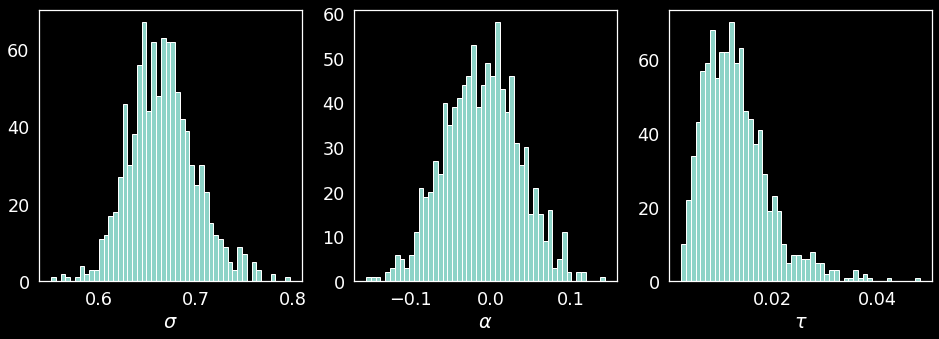

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
axes[0].hist(np.array(samples['sigma']), bins=50);
axes[0].set_xlabel(r'$\sigma$')
axes[1].hist(np.array(samples['alpha']), bins=50);
axes[1].set_xlabel(r'$\alpha$')
axes[2].hist(np.array(samples['tau']), bins=50);
axes[2].set_xlabel(r'$\tau$');
fig.savefig('other_parameters.png', transparent=True, bbox_inches='tight', dpi=300)

sample: 100%|█| 2000/2000 [00:04<00:00, 401.77it/s, 127 steps of size 2.78e-02. 


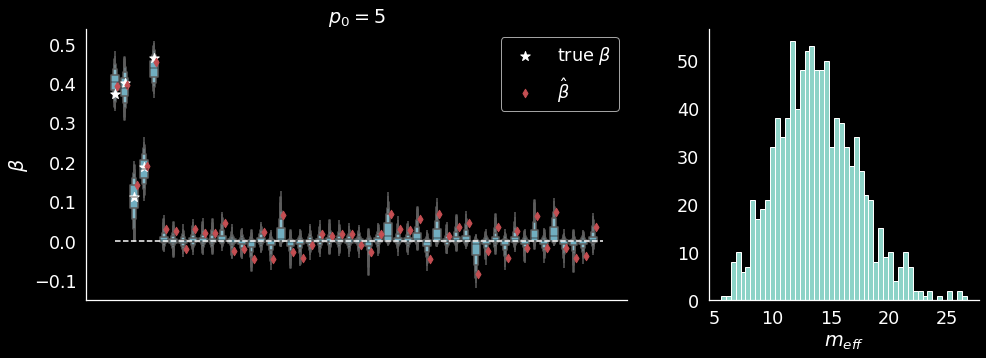

In [11]:
N = 400
X = np.random.randn(N, D)
X, Y1, expected_thetas1, expected_pairwise = get_data(X, S=S, pairwise=False, logistic=False)

_, hat_beta, _ = blr(X, Y1)

rng_key = random.PRNGKey(101)
fig, axes = plt.subplots(1, 2, figsize=(16, 5), gridspec_kw={'width_ratios': [2, 1], 'wspace': 0.2})
p0 = 5
rng_key, _rng_key = random.split(rng_key)
BLR = BayesLinRegress(rng_key, jnp.array(X), fixed_lam=False, p0=p0)
samples = BLR.fit(jnp.array(Y1), summary=False, num_chains=num_chains)

sns.boxenplot(data=np.array(samples['beta']), color='c', ax=axes[0], showfliers=False)
axes[0].scatter(np.arange(S), expected_thetas1, color='w', marker='*', s=100, label=r'true $\beta$')
axes[0].scatter(np.arange(D) + .25, hat_beta, color='r', marker='d', label=r'$\hat{\beta}$')

axes[0].hlines(0, 0, D, 'w', ls='--')
axes[0].set_ylabel(r'$\beta$')
axes[0].set_title(r'$p_0={}$'.format(p0))
axes[0].set_xticks([])
axes[0].legend(loc="upper right")

m_e = m_eff(D, N, p0, np.var(X, 0, ddof=1), samples['sigma'], samples['tau'], samples['lam'])
axes[1].hist(np.array(m_e), bins=50)
axes[1].set_xlabel(r'$m_{eff}$')

sns.despine()

sample: 100%|█| 2000/2000 [00:05<00:00, 354.19it/s, 3 steps of size 3.02e-02. ac


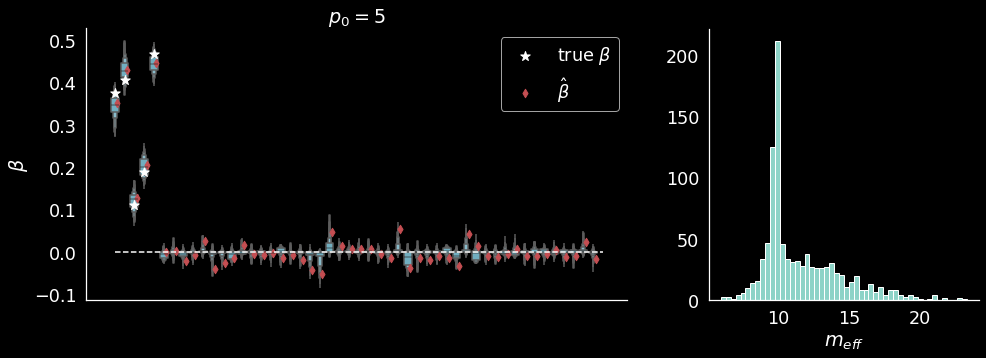

In [12]:
N = 800
X = np.random.randn(N, D)
X, Y1, expected_thetas1, expected_pairwise = get_data(X, S=S, pairwise=False, logistic=False)
_, hat_beta, _ = blr(X, Y1)

rng_key = random.PRNGKey(101)
fig, axes = plt.subplots(1, 2, figsize=(16, 5), gridspec_kw={'width_ratios': [2, 1], 'wspace': 0.2})
p0 = 5
rng_key, _rng_key = random.split(rng_key)
BLR = BayesLinRegress(rng_key, jnp.array(X), fixed_lam=False, p0=p0)
samples = BLR.fit(jnp.array(Y1), summary=False, num_chains=num_chains)

sns.boxenplot(data=np.array(samples['beta']), color='c', ax=axes[0], showfliers=False)
axes[0].scatter(np.arange(S), expected_thetas1, color='w', marker='*', s=100, label=r'true $\beta$')
axes[0].scatter(np.arange(D) + .25, hat_beta, color='r', marker='d', label=r'$\hat{\beta}$')

axes[0].hlines(0, 0, D, 'w', ls='--')
axes[0].set_ylabel(r'$\beta$')
axes[0].set_title(r'$p_0={}$'.format(p0))
axes[0].set_xticks([])
axes[0].legend(loc="upper right")

m_e = m_eff(D, N, p0, np.var(X, 0, ddof=1), samples['sigma'], samples['tau'], samples['lam'])
axes[1].hist(np.array(m_e), bins=50)
axes[1].set_xlabel(r'$m_{eff}$')

sns.despine()

# Correlated predictors

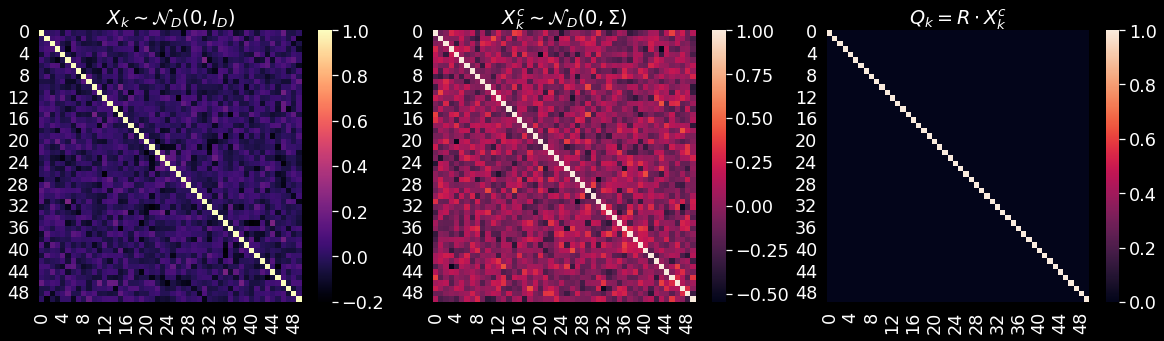

In [23]:
L = dist.LKJCholesky(D, 1.).sample(random.PRNGKey(1))

N = 200
X = np.random.randn(N, D)
X_corr = X @ L.T
X_corr = (X_corr - X_corr.mean(0))/X_corr.std(0)

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

sns.heatmap(np.corrcoef(X.T), ax=axes[0], cmap='magma')
axes[0].set_title(r'$X_k \sim \mathcal{N}_D(0, I_D)$')
sns.heatmap(np.corrcoef(X_corr.T), ax=axes[1])
axes[1].set_title(r'$X_k^c \sim \mathcal{N}_D(0, \Sigma)$')
Q, R = np.linalg.qr(X_corr)
sns.heatmap(np.corrcoef(Q.T), ax=axes[2])
axes[2].set_title(r'$Q_k = R \cdot X_k^c$');
fig.savefig('cm.png', transparent=True, bbox_inches='tight', dpi=300)

sample: 100%|█| 2000/2000 [00:04<00:00, 440.57it/s, 127 steps of size 4.49e-02. 
sample: 100%|█| 2000/2000 [00:03<00:00, 610.04it/s, 127 steps of size 9.11e-02. 
sample: 100%|█| 2000/2000 [00:04<00:00, 450.63it/s, 255 steps of size 8.02e-03. 


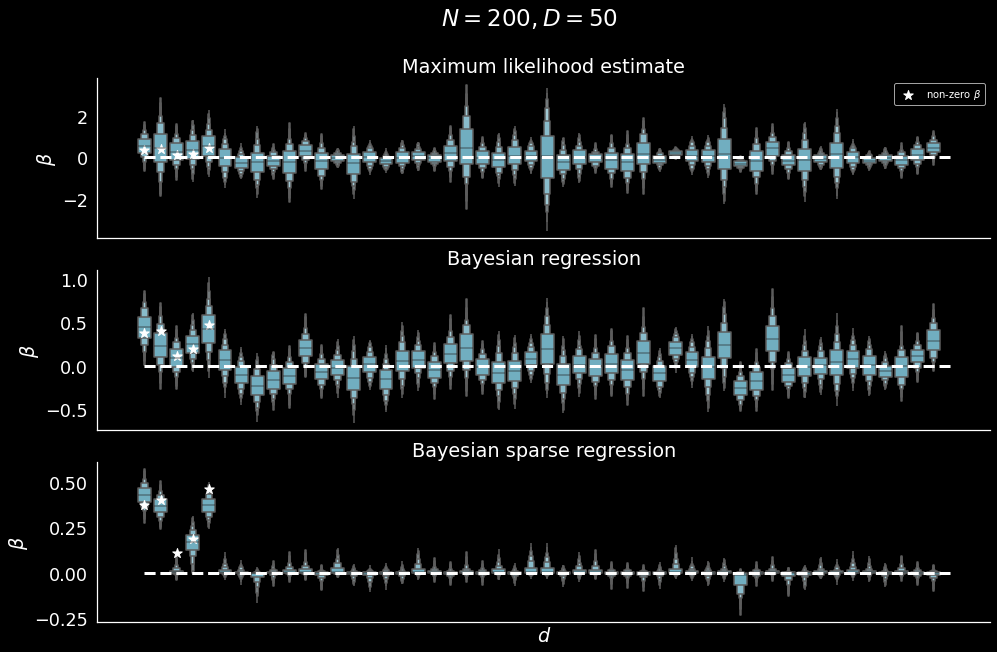

In [29]:
rng_key = random.PRNGKey(101)

N = 200
X = np.random.randn(N, D)
X_corr = X @ L.T
X_corr = (X_corr - X_corr.mean(0))/X_corr.std(0)
X_corr, Y2, expected_thetas2, expected_pairwise = get_data(X_corr, S=S, pairwise=False, logistic=False)

fig, axes = plt.subplots(3, 1, figsize=(16, 10), sharex=True)
p0 = 5
rng_key, _rng_key = random.split(rng_key)
BLR = BayesLinRegress(rng_key, jnp.array(X_corr), fixed_lam=False, p0=5, with_qr=True)
samples = BLR.fit(jnp.array(Y2), summary=False, num_chains=num_chains)

rng_key, _rng_key = random.split(rng_key)
BLR = BayesLinRegress(rng_key, jnp.array(X_corr), fixed_lam=True, p0=None)
samples2 = BLR.fit(jnp.array(Y2), summary=False, num_chains=num_chains)

rng_key, _rng_key = random.split(rng_key)
BLR = BayesLinRegress(rng_key, jnp.array(X_corr), tau=1e3, fixed_lam=True, p0=None)
samples3 = BLR.fit(jnp.array(Y2), summary=False, num_chains=num_chains)

for i, beta in enumerate([samples3['beta'], samples2['beta'], samples['beta']]):
    sns.boxenplot(data=np.array(beta), color='c', ax=axes[i], showfliers=False)
    axes[i].scatter(np.arange(S), expected_thetas2, color='w', marker='*', s=100, label=r'non-zero $\beta$')
    axes[i].hlines(0, 0, D, 'w', ls='--', lw=3)
    axes[i].set_ylabel(r'$\beta$')

axes[-1].set_xticks([])
axes[-1].set_xlabel(r'$d$')
axes[0].legend(loc="upper right", fontsize=10)
fig.suptitle(r'$N={}, D={}$'.format(N, D))
axes[0].set_title('Maximum likelihood estimate')
axes[1].set_title('Bayesian regression')
axes[2].set_title('Bayesian sparse regression')
sns.despine()
fig.savefig('comparison.png', transparent=True, bbox_inches='tight', dpi=300)

# Logistic regression

In [24]:
S = 5
D = 50
N = 800

X = np.random.randn(N, D)
X, Y1_log, expected_thetas1_log, expected_pairwise = get_data(X, S=S, pairwise=False, logistic=True)

L = dist.LKJCholesky(D, 1.).sample(random.PRNGKey(1))
X_corr = X @ L
X_corr = (X_corr - X_corr.mean(0))/X_corr.std(0)
X_corr, Y2_log, expected_thetas2_log, expected_pairwise = get_data(X_corr, S=S, pairwise=False, logistic=True)

In [25]:
class LogisticQRRegress(object):
    def __init__(self, rng_key, X, p0=5):
        self.N, self.D = X.shape
        self.X = X
        
        self.Q, self.R = jnp.linalg.qr(X)
        self.R_inv = jnp.linalg.inv(self.R)
        self.p0 = p0
        
        self.rng_key = rng_key
        
    def model(self, obs=None):
        sigma_sqr = numpyro.sample('sigma^2', dist.InverseGamma(2., 2.))
        sigma = numpyro.deterministic('sigma', jnp.sqrt(sigma_sqr))
        
        tau0 = self.p0 * sigma / ((self.D - self.p0) * jnp.sqrt(self.N))
        tau = numpyro.sample('tau', dist.HalfCauchy(tau0))
        lam = numpyro.sample('lam', dist.HalfCauchy(1.).expand([D]).to_event(1))

        rt = QRTransform(self.R, self.R_inv)
        aff = AffineTransform(0., tau * lam)
        ct = ComposeTransform([aff, rt])
        with handlers.reparam(config={"theta": TransformReparam()}):
            theta = numpyro.sample(
                'theta', 
                dist.TransformedDistribution(dist.Normal(0., 1.).expand([D]).to_event(1), ct)
            )
        
        numpyro.deterministic('beta', rt.inv(theta))
        alpha = numpyro.sample('alpha', dist.Normal(0., 10.))

        mu = numpyro.deterministic('mu', alpha + self.Q.dot(theta))
        
        with numpyro.plate('data', self.N):
            numpyro.sample('obs', dist.Bernoulli(logits=mu), obs=obs)

    def fit(self, data, num_samples=1000, warmup_steps=1000, num_chains=1, summary=True, progress_bar=True):
        self.rng_key, _rng_key = random.split(self.rng_key)

        nuts_kernel = NUTS(self.model, init_strategy=init_to_feasible)
        mcmc = MCMC(nuts_kernel, 
                    num_warmup=warmup_steps, 
                    num_samples=num_samples, 
                    num_chains=num_chains,
                    chain_method='vectorized',
                    progress_bar=progress_bar)
        mcmc.run(_rng_key, obs=data)

        if summary:
            mcmc.print_summary()

        samples = mcmc.get_samples(group_by_chain=False)
        self.mcmc = mcmc
        self.samples = samples

        return samples

sample: 100%|█| 2000/2000 [00:05<00:00, 388.07it/s, 63 steps of size 5.41e-02. a


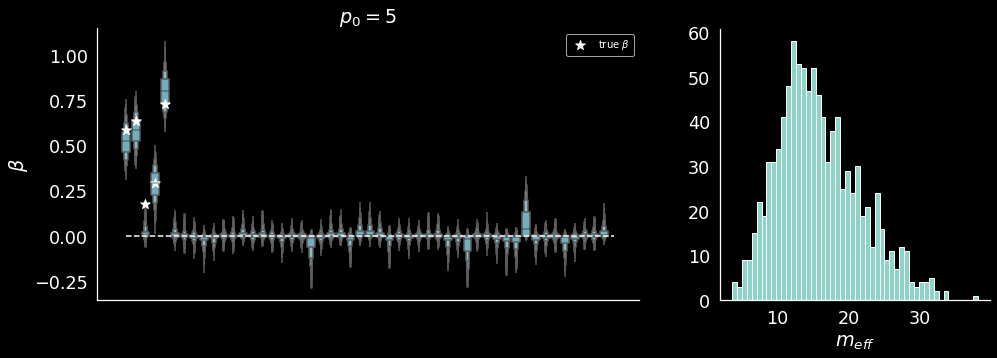

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5), gridspec_kw={'width_ratios': [2, 1], 'wspace': 0.2})
p0 = 5
rng_key, _rng_key = random.split(rng_key)
LQR_reg = LogisticQRRegress(rng_key, jnp.array(X), p0=5)
samples = LQR_reg.fit(jnp.array(Y1_log), summary=False, num_chains=num_chains)

sns.boxenplot(data=np.array(samples['beta']), color='c', ax=axes[0], showfliers=False)
axes[0].scatter(np.arange(S), expected_thetas1_log, color='w', marker='*', s=100, label=r'true $\beta$')
axes[0].hlines(0, 0, D, 'w', ls='--')

axes[0].set_ylabel(r'$\beta$')
axes[0].set_title(r'$p_0={}$'.format(p0))
axes[0].set_xticks([])
axes[0].legend(loc="upper right", fontsize=10)

m_e = m_eff(D, N, p0, np.var(X, 0, ddof=1), samples['sigma'], samples['tau'], samples['lam'])
axes[1].hist(np.array(m_e), bins=50)
axes[1].set_xlabel(r'$m_{eff}$')

sns.despine()

# The kernel interaction trick: 
### Fast bayesian discovery of pairwise interactions in high dimensions.

In [ ]:
X, Y1_pair, expected_thetas1_pair, expected_pairwise = get_data(X, S=S, pairwise=True, logistic=False)
X_corr, Y2_pair, expected_thetas2_pair, expected_pairwise = get_data(X_corr, S=S, pairwise=True, logistic=False)

X, Y1_log_pair, expected_thetas1_log_pair, expected_pairwise = get_data(X, S=S, pairwise=True, logistic=True)
X_corr, Y2_log_pair, expected_thetas2_log_pair, expected_pairwise = get_data(X_corr, S=S, pairwise=True, logistic=True)

In [156]:
def dot(X, Z):
    return jnp.dot(X, Z[..., None])[..., 0]

# The kernel that corresponds to our quadratic regressor.
def kernel(X, Z, eta1, eta2, c):
    eta1sq = jnp.square(eta1)
    eta2sq = jnp.square(eta2)
    K1 = dot(X, Z)
    K2 = dot(jnp.square(X), jnp.square(Z))
    k1 = 0.5 * eta2sq * jnp.square(1.0 + K1)
    k2 = - 0.5 * eta2sq * K2
    k3 = (eta1sq - eta2sq) * K1
    k4 = jnp.square(c) - 0.5 * eta2sq
    return k1 + k2 + k3 + k4

def kernel_diag(X, eta1, eta2, c):
    """
    Computes diagonal elements only.
    """
    K1 = jnp.square(X).sum(-1)
    K2 = jnp.square(jnp.square(X)).sum(-1)
    eta1sq = jnp.square(eta1)
    eta2sq = jnp.square(eta2)
    k1 = 0.5 * eta2sq * jnp.square(1.0 + K1)
    k2 = -0.5 * eta2sq * K2
    k3 = (eta1sq - eta2sq) * K1
    k4 = jnp.square(c) - 0.5 * eta2sq
    return k1 + k2 + k3 + k4

# Most of the model code is concerned with constructing the sparsity inducing prior.
def model(X, hypers, Y=None, subsample_size=None, inducing_points=100):
    S, P, N = hypers["expected_sparsity"], X.shape[1], X.shape[0]
    
    c = numpyro.param('c', 0.1, constraint=dist.constraints.positive) # hypers['c']
    
    sigma = numpyro.sample("sigma", dist.HalfNormal(hypers["alpha3"]))
    
    eta_a = numpyro.sample('eta_a', dist.InverseGamma(.5, 1.))
    eta_b = numpyro.sample('eta_b', dist.InverseGamma(.5, 1.))
    eta = numpyro.deterministic('eta', jnp.sqrt(eta_a * eta_b))

    msq = numpyro.sample("msq", dist.InverseGamma(hypers["alpha1"], hypers["beta1"]))
    xisq = numpyro.sample("xisq", dist.InverseGamma(hypers["alpha2"], hypers["beta2"]))
    
    phi = sigma * (S / jnp.sqrt(N)) / (P - S)
    eta1 = numpyro.deterministic('eta1', phi * eta)
    eta2 = numpyro.deterministic('eta2', jnp.square(eta1) * jnp.sqrt(xisq) / msq)
    
    lam_a = numpyro.sample('lam_a', dist.Gamma(.5, 1.).expand([P]).to_event(1))
    lam_b = numpyro.sample('lam_b', dist.InverseGamma(.5, 1.).expand([P]).to_event(1))
    
    lam = numpyro.deterministic("lambda", jnp.sqrt(lam_a * lam_b))
    kappa = jnp.sqrt(msq) * lam / jnp.sqrt(msq + jnp.square(eta1 * lam))
    
    with numpyro.plate("M", inducing_points):
        Z = numpyro.sample("Z", dist.Normal(0., 1.).expand([P]).to_event(1))
        v = numpyro.sample('v', dist.Normal(0., 1.))
    
    kZ = kappa * Z
    K_mm = kernel(kZ, kZ, eta1, eta2, c) + 1e-6 * jnp.eye(inducing_points)
    L_mm = jnp.linalg.cholesky(K_mm)
    K_mm_inv = jnp.linalg.inv(K_mm)
    
    u =  L_mm @ v # numpyro.sample('u', dist.MultivariateNormal(covariance_matrix=K_mm))
    
    with numpyro.plate("N", N, subsample_size=subsample_size) as idx:
        batch_kX = kappa * X[idx]
        if Y is not None:
            batch_Y = Y[idx]
        else:
            batch_Y = None
    
        K_nm = kernel(batch_kX, kZ, eta1, eta2, c)
        K1 = K_nm @ K_mm_inv
        loc = K1 @ u
        
        diag_K_nn = kernel_diag(batch_kX, eta1, eta2, c) - jnp.diag(K1 @ K_nm.T)
        scale = jnp.sqrt( jnp.square(sigma) +  diag_K_nn )
    
        # sample Y according to the standard gaussian process formula
        numpyro.sample(
            "Y",
            dist.Normal(loc=loc, scale=scale),
            obs=batch_Y
        )

        
# Compute the mean and variance of coefficient theta_i (where i = dimension) for a
# MCMC sample of the kernel hyperparameters (eta1, xisq, ...).
# Compare to theorem 5.1 in reference [1].
def compute_singleton_mean_variance(X, Y, dimension, msq, lam, eta1, xisq, c, sigma):
    P, N = X.shape[1], X.shape[0]

    probe = jnp.zeros((2, P))
    probe = jax.ops.index_update(
        probe, jax.ops.index[:, dimension], jnp.array([1.0, -1.0])
    )

    eta2 = jnp.square(eta1) * jnp.sqrt(xisq) / msq
    kappa = jnp.sqrt(msq) * lam / jnp.sqrt(msq + jnp.square(eta1 * lam))

    kX = kappa * X
    kprobe = kappa * probe

    k_xx = kernel(kX, kX, eta1, eta2, c) + sigma ** 2 * jnp.eye(N)
    k_xx_inv = jnp.linalg.inv(k_xx)
    k_probeX = kernel(kprobe, kX, eta1, eta2, c)
    k_prbprb = kernel(kprobe, kprobe, eta1, eta2, c)

    vec = jnp.array([0.50, -0.50])
    mu = jnp.matmul(k_probeX, jnp.matmul(k_xx_inv, Y))
    mu = jnp.dot(mu, vec)

    var = k_prbprb - jnp.matmul(k_probeX, jnp.matmul(k_xx_inv, jnp.transpose(k_probeX)))
    var = jnp.matmul(var, vec)
    var = jnp.dot(var, vec)

    return mu, var


# Compute the mean and variance of coefficient theta_ij for a MCMC sample of the
# kernel hyperparameters (eta1, xisq, ...). Compare to theorem 5.1 in reference [1].
def compute_pairwise_mean_variance(X, Y, dim1, dim2, msq, lam, eta1, xisq, c, sigma):
    P, N = X.shape[1], X.shape[0]

    probe = jnp.zeros((4, P))
    probe = jax.ops.index_update(
        probe, jax.ops.index[:, dim1], jnp.array([1.0, 1.0, -1.0, -1.0])
    )
    probe = jax.ops.index_update(
        probe, jax.ops.index[:, dim2], jnp.array([1.0, -1.0, 1.0, -1.0])
    )

    eta2 = jnp.square(eta1) * jnp.sqrt(xisq) / msq
    kappa = jnp.sqrt(msq) * lam / jnp.sqrt(msq + jnp.square(eta1 * lam))

    kX = kappa * X
    kprobe = kappa * probe

    k_xx = kernel(kX, kX, eta1, eta2, c) + sigma ** 2 * jnp.eye(N)
    k_xx_inv = jnp.linalg.inv(k_xx)
    k_probeX = kernel(kprobe, kX, eta1, eta2, c)
    k_prbprb = kernel(kprobe, kprobe, eta1, eta2, c)

    vec = jnp.array([0.25, -0.25, -0.25, 0.25])
    mu = jnp.matmul(k_probeX, jnp.matmul(k_xx_inv, Y))
    mu = jnp.dot(mu, vec)

    var = k_prbprb - jnp.matmul(k_probeX, jnp.matmul(k_xx_inv, jnp.transpose(k_probeX)))
    var = jnp.matmul(var, vec)
    var = jnp.dot(var, vec)

    return mu, var


# Sample coefficients theta from the posterior for a given MCMC sample.
# The first P returned values are {theta_1, theta_2, ...., theta_P}, while
# the remaining values are {theta_ij} for i,j in the list `active_dims`,
# sorted so that i < j.
def sample_theta_space(X, Y, active_dims, msq, lam, eta1, xisq, c, sigma):
    P, N, M = X.shape[1], X.shape[0], len(active_dims)
    # the total number of coefficients we return
    num_coefficients = P + M * (M - 1) // 2

    probe = jnp.zeros((2 * P + 2 * M * (M - 1), P))
    vec = jnp.zeros((num_coefficients, 2 * P + 2 * M * (M - 1)))
    start1 = 0
    start2 = 0

    for dim in range(P):
        probe = jax.ops.index_update(
            probe, jax.ops.index[start1 : start1 + 2, dim], jnp.array([1.0, -1.0])
        )
        vec = jax.ops.index_update(
            vec, jax.ops.index[start2, start1 : start1 + 2], jnp.array([0.5, -0.5])
        )
        start1 += 2
        start2 += 1

    for dim1 in active_dims:
        for dim2 in active_dims:
            if dim1 >= dim2:
                continue
            probe = jax.ops.index_update(
                probe,
                jax.ops.index[start1 : start1 + 4, dim1],
                jnp.array([1.0, 1.0, -1.0, -1.0]),
            )
            probe = jax.ops.index_update(
                probe,
                jax.ops.index[start1 : start1 + 4, dim2],
                jnp.array([1.0, -1.0, 1.0, -1.0]),
            )
            vec = jax.ops.index_update(
                vec,
                jax.ops.index[start2, start1 : start1 + 4],
                jnp.array([0.25, -0.25, -0.25, 0.25]),
            )
            start1 += 4
            start2 += 1

    eta2 = jnp.square(eta1) * jnp.sqrt(xisq) / msq
    kappa = jnp.sqrt(msq) * lam / jnp.sqrt(msq + jnp.square(eta1 * lam))

    kX = kappa * X
    kprobe = kappa * probe

    k_xx = kernel(kX, kX, eta1, eta2, c) + sigma ** 2 * jnp.eye(N)
    L = cho_factor(k_xx, lower=True)[0]
    k_probeX = kernel(kprobe, kX, eta1, eta2, c)
    k_prbprb = kernel(kprobe, kprobe, eta1, eta2, c)

    mu = jnp.matmul(k_probeX, cho_solve((L, True), Y))
    mu = jnp.sum(mu * vec, axis=-1)

    Linv_k_probeX = solve_triangular(L, jnp.transpose(k_probeX), lower=True)
    covar = k_prbprb - jnp.matmul(jnp.transpose(Linv_k_probeX), Linv_k_probeX)
    covar = jnp.matmul(vec, jnp.matmul(covar, jnp.transpose(vec)))

    # sample from N(mu, covar)
    L = jnp.linalg.cholesky(covar)
    sample = mu + jnp.matmul(L, np.random.randn(num_coefficients))

    return sample

# Get the mean and variance of a gaussian mixture
def gaussian_mixture_stats(mus, variances):
    mean_mu = jnp.mean(mus)
    mean_var = jnp.mean(variances) + jnp.mean(jnp.square(mus)) - jnp.square(mean_mu)
    return mean_mu, mean_var


# Helper function for analyzing the posterior statistics for coefficient theta_i
def analyze_dimension(samples, X, Y, dimension, hypers):
    vmap_args = (
        samples["msq"],
        samples["lambda"],
        samples["eta1"],
        samples["xisq"],
        samples["sigma"],
    )
    mus, variances = vmap(
        lambda msq, lam, eta1, xisq, sigma: compute_singleton_mean_variance(
            X, Y, dimension, msq, lam, eta1, xisq, hypers["c"], sigma
        )
    )(*vmap_args)
    mean, variance = gaussian_mixture_stats(mus, variances)
    std = jnp.sqrt(variance)
    return mean, std


# Helper function for analyzing the posterior statistics for coefficient theta_ij
def analyze_pair_of_dimensions(samples, X, Y, dim1, dim2, hypers):
    vmap_args = (
        samples["msq"],
        samples["lambda"],
        samples["eta1"],
        samples["xisq"],
        samples["sigma"],
    )
    mus, variances = vmap(
        lambda msq, lam, eta1, xisq, sigma: compute_pairwise_mean_variance(
            X, Y, dim1, dim2, msq, lam, eta1, xisq, hypers["c"], sigma
        )
    )(*vmap_args)
    mean, variance = gaussian_mixture_stats(mus, variances)
    std = jnp.sqrt(variance)
    return mean, std

In [7]:
num_samples = 1000
num_data = min(10000, train_X.shape[0])
num_dimensions = train_X.shape[-1]
active_dimensions = 2

mean = train_X.mean(0)
std = train_X.std(0, ddof=1)
standard_X = (train_X[-num_data:] - mean)/std

X, Y, expected_thetas, expected_pairwise = get_data(standard_X, S=active_dimensions)

# setup hyperparameters
hypers = {
    "expected_sparsity": max(1.0, num_dimensions / 10),
    "alpha1": 3.0,
    "beta1": 1.0,
    "alpha2": 3.0,
    "beta2": 1.0,
    "alpha3": 1.0
}

rng_key = random.PRNGKey(10101)

prior_predictive = Predictive(model, num_samples=1)
rng_key, _rng_key = random.split(rng_key)
prior_pred = prior_predictive(_rng_key, X, hypers, subsample_size=1000)

100%|█| 10000/10000 [00:11<00:00, 851.17it/s, init loss: 13361.7939, avg. loss [


CPU times: user 27.3 s, sys: 1.86 s, total: 29.2 s
Wall time: 25.8 s


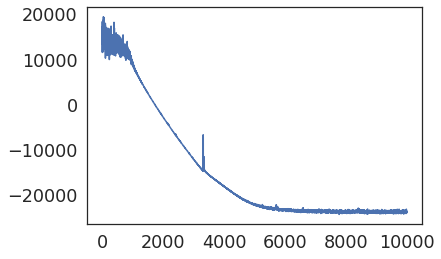

In [8]:
%%time
num_svi_steps = 10000

# do inference
rng_key, _rng_key = random.split(rng_key)

optimizer = numpyro.optim.Adam(step_size=1e-3)
guide = autoguide.AutoDelta(model)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO(num_particles=1))
svi_result = svi.run(_rng_key, num_svi_steps, X, hypers, stable_update=True, Y=Y, subsample_size=1000, inducing_points=32)
params, losses = svi_result.params, svi_result.losses
plt.plot(losses)

In [87]:
ref_params = dict([(key.split('_')[0], value) for (key, value) in params.items()])

In [46]:
num_blocks = 10
num_warmup = 1000
rng_key, _rng_key = random.split(rng_key)
proxy = HMCECS.taylor_proxy(ref_params)

inner_kernel = NUTS(model, init_strategy=init_to_value(values=ref_params), dense_mass=False)
hmcecs_kernel = HMCECS(inner_kernel, num_blocks=num_blocks, proxy=proxy)
mcmc = MCMC(hmcecs_kernel, num_warmup=num_warmup, num_samples=num_samples)

mcmc.run(_rng_key, X, hypers, Y=Y, subsample_size=100, inducing_points=100)
mcmc.print_summary()

samples = mcmc.get_samples()

TypeError: '>' not supported between instances of 'int' and 'NoneType'

100%|█| 20000/20000 [01:21<00:00, 246.47it/s, init loss: 25267.4980, avg. loss [


CPU times: user 1min 29s, sys: 2.08 s, total: 1min 31s
Wall time: 1min 23s


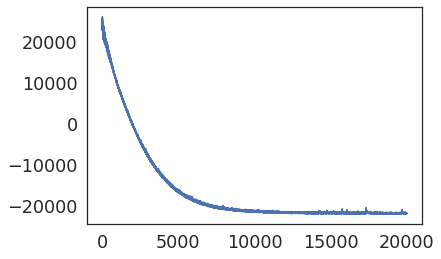

In [90]:
%%time
num_svi_steps = 20000

# do inference
rng_key, _rng_key = random.split(rng_key)

optimizer = numpyro.optim.Adam(step_size=1e-3)
guide = autoguide.AutoNormal(model)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO(num_particles=10))
svi_result = svi.run(_rng_key, num_svi_steps, X, hypers, stable_update=True, Y=Y, subsample_size=1000, inducing_points=128)
params, losses = svi_result.params, svi_result.losses
plt.plot(losses)

In [95]:
samples = Predictive(model, guide=guide, params=params, num_samples=num_samples, return_sites=["msq", "lambda", "eta1", "xisq", "sigma"])(_rng_key, X, hypers, Y=Y, inducing_points=128)
hypers['c'] = params['c']

In [96]:
 # compute the mean and square root variance of each coefficient theta_i
means, stds = vmap(lambda dim: analyze_dimension(samples, X, Y, dim, hypers))(
    jnp.arange(num_dimensions)
)

print(
    "Coefficients theta_1 to theta_%d used to generate the data:"
    % active_dimensions,
    expected_thetas,
)
print(
    "The single quadratic coefficient theta_{1,2} used to generate the data:",
    expected_pairwise,
)

2022-01-09 13:26:44.013086: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 286.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


RuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 307387801216 bytes.

In [18]:
act_dimensions = []

for dim, (mean, std) in enumerate(zip(means, stds)):
    # we mark the dimension as inactive if the interval [mean - 3 * std, mean + 3 * std] contains zero
    lower, upper = mean - 3.0 * std, mean + 3.0 * std
    inactive = "inactive" if lower < 0.0 and upper > 0.0 else "active"
    if inactive == "active":
        act_dimensions.append(dim)
    print(
        "[dimension %02d/%02d]  %s:\t%.2e +- %.2e"
        % (dim + 1, num_dimensions, inactive, mean, std)
    )

print(
    "Identified a total of %d active dimensions; expected %d."
    % (len(act_dimensions), active_dimensions)
)

[dimension 01/22]  active:	7.52e-01 +- 2.02e-01
[dimension 02/22]  inactive:	1.87e-02 +- 8.82e-02
[dimension 03/22]  active:	7.13e-01 +- 4.44e-02
[dimension 04/22]  active:	6.60e-01 +- 4.44e-02
[dimension 05/22]  active:	5.26e-01 +- 1.48e-02
[dimension 06/22]  inactive:	8.92e-04 +- 7.29e-03
[dimension 07/22]  inactive:	1.37e-03 +- 7.29e-03
[dimension 08/22]  inactive:	-2.06e-04 +- 7.57e-03
[dimension 09/22]  inactive:	-1.18e-04 +- 7.72e-03
[dimension 10/22]  inactive:	5.94e-05 +- 7.76e-03
[dimension 11/22]  inactive:	3.74e-05 +- 7.89e-03
[dimension 12/22]  inactive:	-1.46e-04 +- 8.01e-03
[dimension 13/22]  inactive:	3.57e-03 +- 9.73e-03
[dimension 14/22]  inactive:	9.74e-04 +- 7.25e-03
[dimension 15/22]  inactive:	1.10e-03 +- 7.23e-03
[dimension 16/22]  inactive:	-5.52e-05 +- 7.56e-03
[dimension 17/22]  inactive:	6.92e-04 +- 7.79e-03
[dimension 18/22]  inactive:	-1.75e-05 +- 7.80e-03
[dimension 19/22]  inactive:	2.84e-04 +- 7.21e-03
[dimension 20/22]  inactive:	3.48e-04 +- 7.20e-03
[di

In [19]:
# Compute the mean and square root variance of coefficients theta_ij for i,j active dimensions.
# Note that the resulting numbers are only meaningful for i != j.
if len(act_dimensions) > 0:
    dim_pairs = jnp.array(
        list(itertools.product(act_dimensions, act_dimensions))
    )
    means, stds = vmap(
        lambda dim_pair: analyze_pair_of_dimensions(
            samples, X, Y, dim_pair[0], dim_pair[1], hypers
        )
    )(dim_pairs)
    for dim_pair, mean, std in zip(dim_pairs, means, stds):
        dim1, dim2 = dim_pair
        if dim1 >= dim2:
            continue
        lower, upper = mean - 3.0 * std, mean + 3.0 * std
        if not (lower < 0.0 and upper > 0.0):
            format_str = "Identified pairwise interaction between dimensions %d and %d: %.2e +- %.2e"
            print(format_str % (dim1 + 1, dim2 + 1, mean, std))
    # Draw a single sample of coefficients theta from the posterior, where we return all singleton
    # coefficients theta_i and pairwise coefficients theta_ij for i, j active dimensions. We use the
    # final MCMC sample obtained from the HMC sampler.
    thetas = sample_theta_space(
        X,
        Y,
        act_dimensions,
        samples["msq"][-1],
        samples["lambda"][-1],
        samples["eta1"][-1],
        samples["xisq"][-1],
        hypers["c"],
        samples["sigma"][-1],
    )
    print("Single posterior sample theta:\n", thetas)

Single posterior sample theta:
 [ 0.59230757 -0.00592068  0.70160383  0.65204215  0.47032997 -0.00435046
  0.00194703  0.00379953 -0.00487796  0.00636354 -0.00476436  0.00094282
  0.0042872   0.00212575 -0.00184985  0.00591729  0.00369132  0.00877468
 -0.00264011  0.00512314  0.00158338  0.00752553 -0.25307614 -0.52416134
 -0.31714892  0.0771629  -0.02347397 -0.03404973]


In [27]:
for samples, Y in zip(post_samples, [Y_1, Y_2]):
  
    # compute the mean and square root variance of each coefficient theta_i
    means, stds = vmap(lambda dim: analyze_dimension(samples, X, Y, dim, hypers))(
        jnp.arange(num_dimensions)
    )

    act_dimensions = []

    for dim, (mean, std) in enumerate(zip(means, stds)):
        # we mark the dimension as inactive if the interval [mean - 3 * std, mean + 3 * std] contains zero
        lower, upper = mean - 2.0 * std, mean + 2.0 * std
        inactive = "inactive" if lower < 0.0 and upper > 0.0 else "active"
        if inactive == "active":
            act_dimensions.append(dim)
        print(
            "[dimension %02d/%02d]  %s:\t%.2e +- %.2e"
            % (dim + 1, num_dimensions, inactive, mean, std)
        )

    print(
        "Identified a total of %d active dimensions; expected %d."
        % (len(act_dimensions), active_dimensions)
    )
    
    # Compute the mean and square root variance of coefficients theta_ij for i,j active dimensions.
    # Note that the resulting numbers are only meaningful for i != j.
    if len(act_dimensions) > 0:
        dim_pairs = jnp.array(
            list(itertools.product(act_dimensions, act_dimensions))
        )
        means, stds = vmap(
            lambda dim_pair: analyze_pair_of_dimensions(
                samples, X, Y, dim_pair[0], dim_pair[1], hypers
            )
        )(dim_pairs)
        for dim_pair, mean, std in zip(dim_pairs, means, stds):
            dim1, dim2 = dim_pair
            if dim1 >= dim2:
                continue
            lower, upper = mean - 2.0 * std, mean + 2.0 * std
            if not (lower < 0.0 and upper > 0.0):
                format_str = "Identified pairwise interaction between dimensions %d and %d: %.2e +- %.2e"
                print(format_str % (dim1 + 1, dim2 + 1, mean, std))
        # Draw a single sample of coefficients theta from the posterior, where we return all singleton
        # coefficients theta_i and pairwise coefficients theta_ij for i, j active dimensions. We use the
        # final MCMC sample obtained from the HMC sampler.
        thetas = sample_theta_space(
            X,
            Y,
            act_dimensions,
            samples["msq"][-1],
            samples["lambda"][-1],
            samples["eta1"][-1],
            samples["xisq"][-1],
            hypers["c"],
            samples["sigma"][-1],
        )
        print("Single posterior sample theta:\n", thetas)

[dimension 01/22]  inactive:	1.02e-02 +- 1.02e-01
[dimension 02/22]  inactive:	5.47e-01 +- 3.33e-01
[dimension 03/22]  inactive:	2.39e-02 +- 6.66e-02
[dimension 04/22]  inactive:	1.57e-01 +- 1.03e-01
[dimension 05/22]  inactive:	3.18e-02 +- 4.22e-02
[dimension 06/22]  inactive:	-1.50e-02 +- 3.12e-02
[dimension 07/22]  inactive:	-4.06e-02 +- 2.98e-02
[dimension 08/22]  inactive:	1.76e-02 +- 3.07e-02
[dimension 09/22]  inactive:	-3.14e-03 +- 4.03e-02
[dimension 10/22]  inactive:	-6.67e-03 +- 6.41e-02
[dimension 11/22]  inactive:	-3.30e-02 +- 4.03e-02
[dimension 12/22]  inactive:	-3.49e-02 +- 9.14e-02
[dimension 13/22]  inactive:	-9.62e-03 +- 3.28e-02
[dimension 14/22]  inactive:	8.37e-03 +- 1.22e-02
[dimension 15/22]  inactive:	1.27e-02 +- 1.63e-02
[dimension 16/22]  inactive:	1.01e-02 +- 2.36e-02
[dimension 17/22]  inactive:	1.02e-02 +- 3.29e-02
[dimension 18/22]  inactive:	4.85e-02 +- 5.92e-02
[dimension 19/22]  inactive:	-8.28e-03 +- 1.83e-02
[dimension 20/22]  inactive:	2.57e-02 +- 5

In [ ]:
from jax import nn, lax
from jax.scipy.special import logsumexp
from numpyro.infer.reparam import TransformReparam

import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, log_likelihood, Predictive
from numpyro.distributions.transforms import Transform, AffineTransform, ComposeTransform
from numpyro.distributions import constraints
from numpyro.infer.initialization import init_to_feasible
from numpyro import handlers

class QRTransform(Transform):
    domain = constraints.real_vector
    codomain = constraints.real_vector

    def __init__(self, R, R_inv):
        if jnp.ndim(R) != 2:
            raise ValueError(
                "Only support 2-dimensional R matrix. "
            )
        self.R = R
        self.R_inv = R_inv

    def __call__(self, x):
        return jnp.squeeze(
            jnp.matmul(self.R, x[..., jnp.newaxis]), axis=-1
        )

    def _inverse(self, y):
        return jnp.squeeze(
            jnp.matmul(self.R_inv, y[..., jnp.newaxis]), axis=-1
        )

    def log_abs_det_jacobian(self, x, y, intermediates=None):
        return jnp.broadcast_to(
            jnp.log(jnp.diagonal(self.R, axis1=-2, axis2=-1)).sum(-1),
            jnp.shape(x)[:-1],
        )

    def forward_shape(self, shape):
        if len(shape) < 1:
            raise ValueError("Too few dimensions on input")
        return lax.broadcast_shapes(shape, self.R.shape[:-1])

    def inverse_shape(self, shape):
        if len(shape) < 1:
            raise ValueError("Too few dimensions on input")
        return lax.broadcast_shapes(shape, self.R.shape[:-1])

class BayesLinRegress(object):
    def __init__(self, rng_key, X, p0=5, normal=True):
        self.count, self.dim_factors = X.shape
        self.x_data = X
        self.normal = normal
        
        self.Q, self.R = jnp.linalg.qr(self.x_data)
        self.R_inv = jnp.linalg.inv(self.R)
        self.p0 = p0
        
        self.rng_key = rng_key
        
    def update_predictors(self, X):
        self.x_data = X
        self.Q = self.x_data.dot(self.R_inv)

    def model(self, obs=None):
        T, D = self.Q.shape
        
        sigma_sqr = numpyro.sample('sigma^2', dist.InverseGamma(3./2., 1.))
        sigma = numpyro.deterministic('sigma', jnp.sqrt(sigma_sqr))
        c_sqr = numpyro.sample('c^2', dist.InverseGamma(3./2., 6.))
        tau_0 = numpyro.deterministic('tau_0', self.p0 * 1000. * sigma / ((self.dim_factors - self.p0) * jnp.sqrt(self.count)))
        var_tau = numpyro.sample('var_tau', dist.HalfCauchy(1.))
        tau = numpyro.deterministic('tau', tau_0 * var_tau)
        lam = numpyro.sample('lam', dist.HalfCauchy(1.).expand([D]).to_event(1))
        lam_sqr = lam ** 2
        tilde_lam = numpyro.deterministic('tilde_lam', c_sqr * lam_sqr /(c_sqr + tau**2 * lam_sqr))
        rt = QRTransform(self.R, self.R_inv)
        aff = AffineTransform(0., tau * lam)
        ct = ComposeTransform([aff, rt])
        with handlers.reparam(config={"theta": TransformReparam()}):
            theta = numpyro.sample(
                'theta', 
                dist.TransformedDistribution(dist.Normal(0., 1.).expand([D]).to_event(1), ct)
            )
        
        numpyro.deterministic('beta', rt.inv(theta))
        alpha = numpyro.sample('alpha', dist.Normal(0., 100.))

        mu = numpyro.deterministic('mu', alpha + self.Q.dot(theta))
        
        if self.normal:
            with numpyro.plate('data_dim', T):
                numpyro.sample('obs', dist.Normal(mu, sigma), obs=obs)
        else:
            nu = numpyro.sample('nu', dist.HalfCauchy(1.))
            with numpyro.plate('data_dim', T):
                numpyro.sample('obs', dist.StudentT(nu + 1, mu, sigma), obs=obs)

    def fit(self, data, num_samples=1000, warmup_steps=2000, num_chains=1, summary=True, progress_bar=True):
        self.rng_key, _rng_key = random.split(self.rng_key)

        nuts_kernel = NUTS(self.model, init_strategy=init_to_feasible)
        mcmc = MCMC(nuts_kernel, 
                    num_warmup=warmup_steps, 
                    num_samples=num_samples, 
                    num_chains=num_chains,
                    chain_method='vectorized',
                    progress_bar=progress_bar)
        mcmc.run(_rng_key, obs=data)

        if summary:
            mcmc.print_summary()

        samples = mcmc.get_samples(group_by_chain=False)
        self.mcmc = mcmc
        self.samples = samples

        return samples

    def predictions(self):
        self.rng_key, rng_key_ = random.split(self.rng_key)
        predictive = Predictive(self.model, self.samples)
        
        return predictive(rng_key_)['obs']